<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/11_4_Bahdanau_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00


## 11.4 The Bahdanau Attention Mechanism

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

### 11.4.2 Defining the Decoder with Attention

In [3]:
class AttentionDecoder(d2l.Decoder):
  def __init__(self):
    super().__init__()

  @property
  def attention_weights(self):
    raise NotImplementedError

In [4]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
    super().__init__()
    self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(
        embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
    self.dense = nn.LazyLinear(vocab_size)
    self.apply(d2l.init_seq2seq)

  def init_state(self, enc_outputs, enc_valid_lens):
    # Shape of outputs: (num_steps, batch_size, num_hiddens)
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
    outputs, hidden_state = enc_outputs
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

  def forward(self, X, state):
    # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
    # Shape of hidden_state: (num_layers, batch_size, num_hiddens).
    enc_outputs, hidden_state, enc_valid_lens = state
    # Shape of the output X: (num_steps, batch_size, embed_size).
    X = self.embedding(X).permute(1, 0, 2)
    outputs, self._attention_weights = [], []
    for x in X:
      # Shape of query: (batch_size, 1, num_hiddnes)
      query = torch.unsqueeze(hidden_state[-1], dim=1)
      # Shape of context: (batch_size, 1, num_hiddens)
      context = self.attention(
          query, enc_outputs, enc_outputs, enc_valid_lens)
      # Concatenate on the feature dimension
      x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
      # Reshape x as (1, batch_size, embed_size + num_hiddens)
      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
      outputs.append(out)
      self._attention_weights.append(self.attention.attention_weights)
    # After fully connected layer transformations, shape of outputs:
    # (num_steps, batch_size, vocab_size)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

In [5]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### 11.4.3 Training

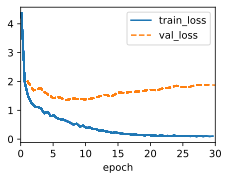

In [6]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, 
                             num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, 
                                  num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)